In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib as mpl
import numpy as np
import pyemma
import glob
import pandas as pd

import nglview
import mdtraj
from mdtraj import shrake_rupley, compute_rg
from threading import Timer
from nglview.player import TrajectoryPlayer

import MDAnalysis as mda
from MDAnalysis.analysis import diffusionmap,align, rms

cmap = 'cool'
norm = Normalize(vmin=0, vmax=1)

***
### Feature Selection

In [12]:
# Get topology and trajectory files. 
# Split trajectories into training set [:-1] and test set [-1]

gro = './data/peptide.gro'
trj = glob.glob('./data/md_1us_*_noPBC.xtc')
train_files = trj[:-1]
test_file = trj[-1]
print('Training files:', *train_files, '\nTest files:', test_file)
assert set(train_files) & set(test_file) == set()

Training files: ./data/md_1us_3_noPBC.xtc ./data/md_1us_1_noPBC.xtc ./data/md_1us_2_noPBC.xtc 
Test files: ./data/md_1us_0_noPBC.xtc


In [ ]:
# Have a look at the structure

widget = nglview.show_mdtraj(mdtraj.load(gro))
p = TrajectoryPlayer(widget)
widget.add_ball_and_stick()
p.spin = True
def stop_spin():
    p.spin = False
    widget.close()
Timer(30, stop_spin).start()
widget

Obtaining file info:   0%|                                                                        | 0/3 [00:00…

getting output of FeatureReader:   0%|                                                            | 0/3 [00:00…

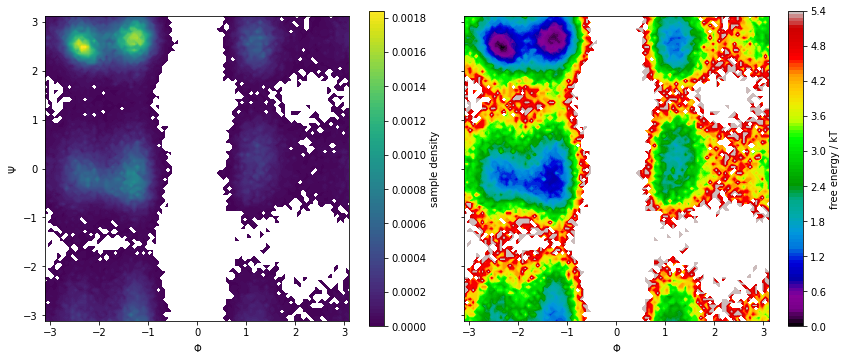

In [43]:
# Ramachandran plot and free energy plot 

feat_torsion = pyemma.coordinates.featurizer(gro)
feat_torsion.add_backbone_torsions(periodic=False)
reader_torsion = pyemma.coordinates.source(trj, features = feat_torsion)
data_plot = reader_torsion.get_output(stride = 3)

phi = np.concatenate(data_plot[0][:,::2])
psi = np.concatenate(data_plot[0][:,1::2])

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
pyemma.plots.plot_density(phi, psi, ax=axes[0])
pyemma.plots.plot_free_energy(phi, psi, ax=axes[1], legacy=False)
for ax in axes.flat:
    ax.set_xlabel('$\Phi$')
    ax.set_aspect('equal')
axes[0].set_ylabel('$\Psi$')
fig.tight_layout()
plt.savefig(fname = './figures/Ramachandran.png')

In [31]:
# Select features by comparing VAMP scores at different lag times 
feat = pyemma.coordinates.featurizer(gro)
stride = 10

# backbone torsions
feat.active_features = []
feat.add_backbone_torsions(periodic=False)
data_backbone = pyemma.coordinates.load(train_files, features=feat, stride = stride)
data_backbone_test = pyemma.coordinates.load(test_file, features=feat, stride = stride)
print('Backbone torsions dimension: ',feat.dimension())

# ca distances
feat.active_features = []
feat.add_distances_ca(periodic=False)
data_ca = pyemma.coordinates.load(train_files, features=feat, stride = stride)
data_ca_test = pyemma.coordinates.load(test_file, features=feat, stride = stride)
print('Ca distances dimension: ',feat.dimension())

# sidechain torsions
feat.active_features = []
feat.add_sidechain_torsions(periodic=False)
data_sidechain = pyemma.coordinates.load(train_files, features=feat, stride = stride)
data_sidechain_test = pyemma.coordinates.load(test_file, features=feat, stride = stride)
print('Sidechain torsions dimension:',feat.dimension())

# backbone torsions + ca distances
feat.active_features = []
feat.add_backbone_torsions(periodic=False)
feat.add_distances_ca(periodic=False)
data_backbone_ca = pyemma.coordinates.load(train_files, features=feat, stride = stride)
data_backbone_ca_test = pyemma.coordinates.load(test_file, features=feat, stride = stride)
print('Backbone torsions + Ca distances dimension: ',feat.dimension())

# Ca distances + sidechain torsions
feat.active_features = []
feat.add_distances_ca(periodic=False)
feat.add_sidechain_torsions(periodic=False)
data_ca_sidechain = pyemma.coordinates.load(train_files, features=feat, stride = stride)
data_ca_sidechain_test = pyemma.coordinates.load(test_file, features=feat, stride = stride)
print('Ca distances + sidechain torsions dimension:',feat.dimension())

# backbone torsions + sidechain torsions
feat.active_features = []
feat.add_backbone_torsions(periodic=False)
feat.add_sidechain_torsions(periodic=False)
data_backbone_sidechain = pyemma.coordinates.load(train_files, features=feat, stride = stride)
data_backbone_sidechain_test = pyemma.coordinates.load(test_file, features=feat, stride = stride)
print('Backbone torsions + sidechain torsions dimension:',feat.dimension())

# backbone torsions + ca distances + sidechain torsions
feat.active_features = []
feat.add_backbone_torsions(periodic=False)
feat.add_distances_ca(periodic=False)
feat.add_sidechain_torsions(periodic=False)
data_backbone_ca_sidechain = pyemma.coordinates.load(train_files, features=feat, stride = stride)
data_backbone_ca_sidechain_test = pyemma.coordinates.load(test_file, features=feat, stride = stride)
print('Backbone torsions + Ca distances + sidechain torsions dimension:',feat.dimension())

data_list = [data_backbone, data_ca, data_sidechain, data_backbone_ca, data_ca_sidechain, data_backbone_sidechain, data_backbone_ca_sidechain]
test_data_list = [data_backbone_test, data_ca_test, data_sidechain_test, data_backbone_ca_test, data_ca_sidechain_test, data_backbone_sidechain_test, data_backbone_ca_sidechain_test]
label_list = ['BackBone', 'Ca_Dists', 'SideChain','BB+Ca', 'Ca+SC', 'BB+SC', 'BB+CA+SC']

Backbone torsions dimension:  28
Ca distances dimension:  78


/home/rzhu/miniconda3/envs/pyemma_tutorials/lib/python3.9/site-packages/pyemma/coordinates/data/featurization/angles.py:211: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  indices = np.vstack(valid.values())


Sidechain torsions dimension: 18
Backbone torsions + Ca distances dimension:  106
Ca distances + sidechain torsions dimension: 96
Backbone torsions + sidechain torsions dimension: 46
Backbone torsions + Ca distances + sidechain torsions dimension: 124


In [27]:
def plot_for_lag(ax, lag, data_list, test_data_list, label_list, dim=5):
    vamps = []
    test_data = []
    labels = []
    for i, data in enumerate(data_list):
        if data[0].shape[1] >= dim: 
            vamps.append(pyemma.coordinates.vamp(data, lag = lag, dim = dim))
            test_data.append(test_data_list[i])
            labels.append(label_list[i])
    for i, (v, test_data) in enumerate(zip(vamps, test_data)):
        if dim > v.dimension(): continue
        s = v.score(test_data = test_data)
        ax.bar(i, s)
    ax.set_xticks(range(len(vamps)))
    ax.set_xticklabels(labels, rotation = 60)

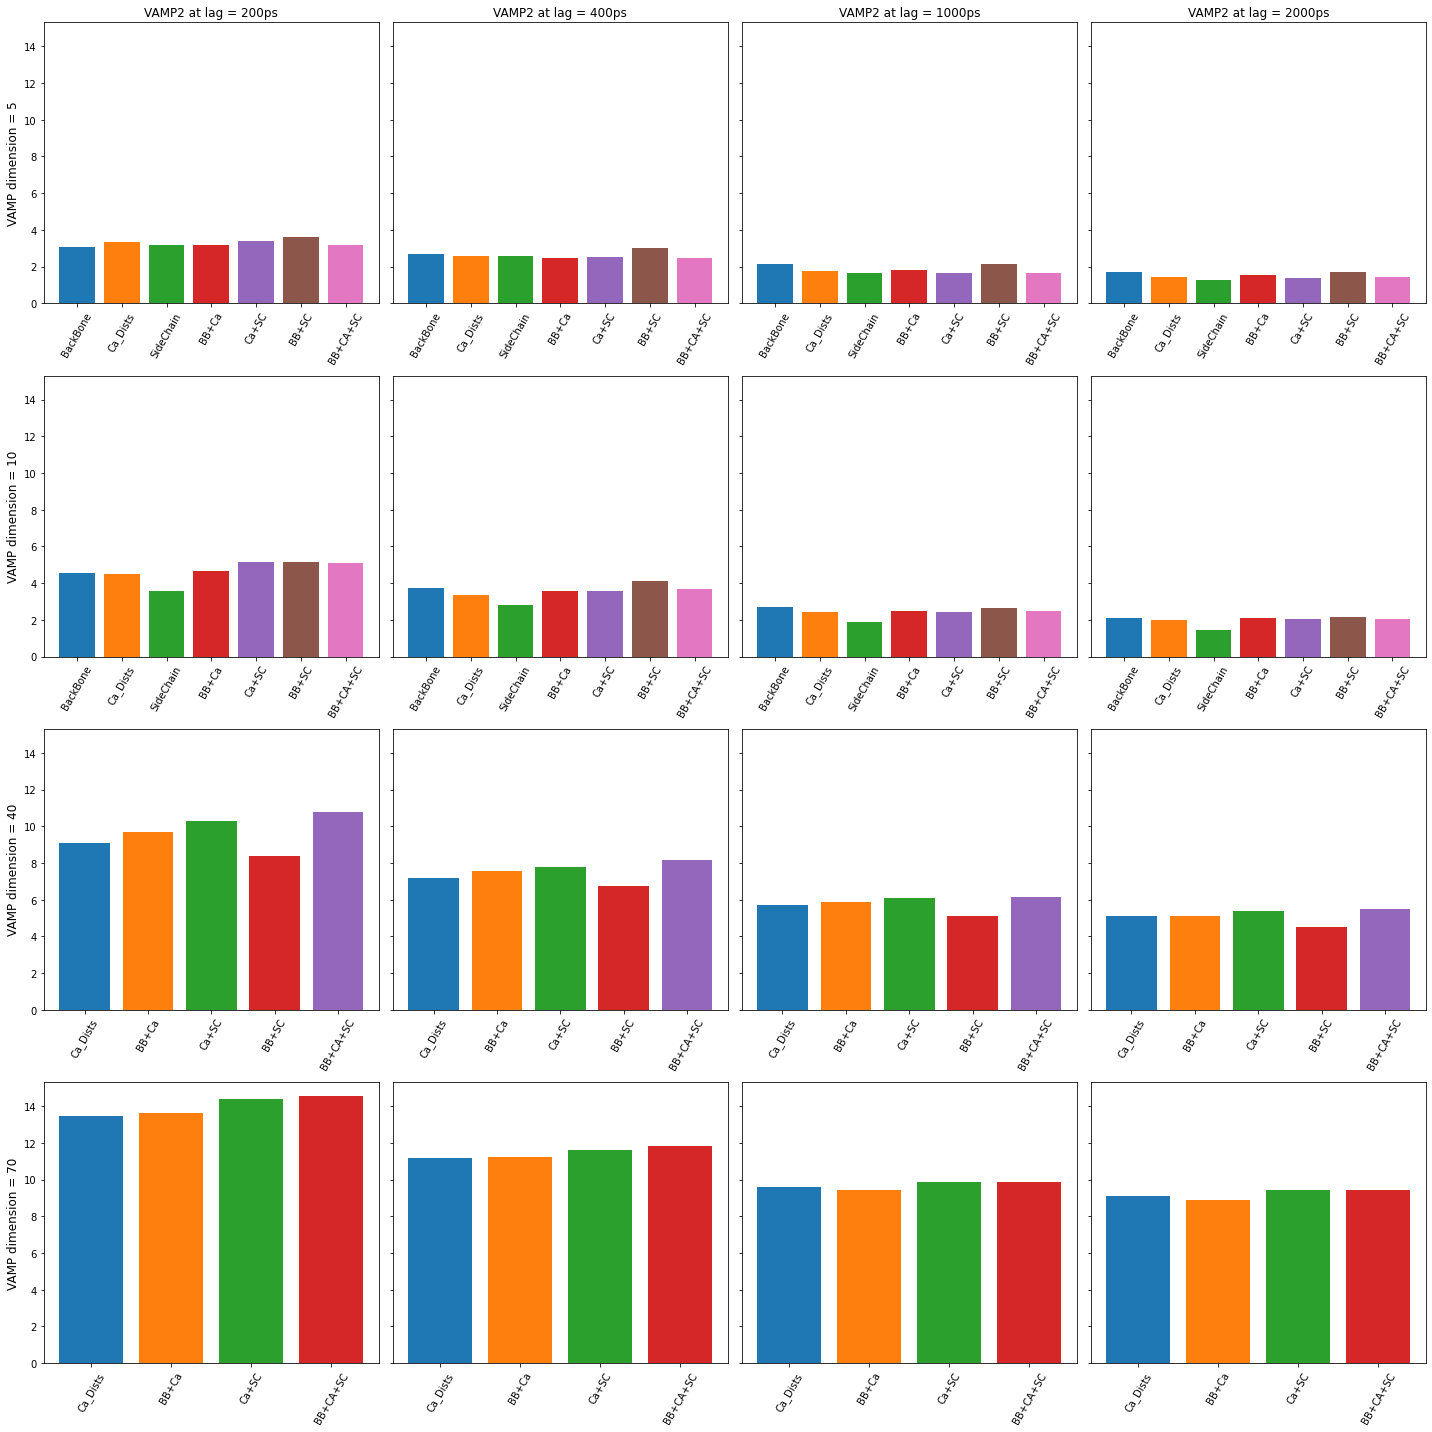

In [32]:
# Compute VAMP scores at different lag times and dimensions
# This is to ensure that our selected feature is robust as a function of lag time
# and to select features by comparing VAMP scores 

dimensions = [5, 10, 40, 70]
lagtimes = [5, 10, 25, 50]

fig, axes = plt.subplots(len(dimensions), 4, figsize=(5*len(lagtimes), 5*len(dimensions)), sharey = True)
for i, dim in enumerate(dimensions):
    for j, lag in enumerate(lagtimes):
        plot_for_lag(axes[i,j], lag, data_list, test_data_list, label_list, dim = dim)
for ax, lag in zip(axes[0], lagtimes):
    ax.set_title('VAMP2 at lag = {}ps'.format(lag*40), size = 'large')
for ax, dim in zip(axes[:,0], dimensions):
    ax.set_ylabel('VAMP dimension = {}'.format(dim), rotation = 90, size = 'large')
fig.tight_layout()
plt.savefig(fname = './figures/VAMP_scores.png')

***
### Dimensionality Reduction and Discretisation

In [14]:
# Number of orginal features = sidechain torsions (18) + ca distances (78) = 96
# Concatenate trajectories
# Perform TICA and VAMP transformation on the feature space and reduce the feature space dimensions to (60*length)

feat = pyemma.coordinates.featurizer(gro)
feat.active_features = []
feat.add_sidechain_torsions(periodic = False)
feat.add_distances_ca(periodic = False)
reader = pyemma.coordinates.source(trj, features = feat)

tica = pyemma.coordinates.tica(reader, lag = 25, var_cutoff = 0.95, stride = 3)
tica_output = tica.get_output(stride = 1)
tica_concatenated = np.concatenate(tica_output)
vamp = pyemma.coordinates.vamp(reader, lag = 25, dim = 0.95, stride = 3)
vamp_output = vamp.get_output(stride = 1)
vamp_concatenated = np.concatenate(vamp_output)
tica.save('./models/4us.pyemma', model_name = 'tica_lag_25', overwrite = True)

print('TICA subspace shape', tica_concatenated.shape)
print('VAMP subspace shape', vamp_concatenated.shape)

/home/rzhu/miniconda3/envs/pyemma_tutorials/lib/python3.9/site-packages/pyemma/coordinates/data/featurization/angles.py:211: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  indices = np.vstack(valid.values())


Obtaining file info:   0%|                                                                        | 0/4 [00:00…

calculate covariances:   0%|                                                                      | 0/4 [00:00…

getting output of TICA:   0%|                                                                     | 0/4 [00:00…

calculate covariances:   0%|                                                                      | 0/4 [00:00…

getting output of VAMP:   0%|                                                                     | 0/4 [00:00…

TICA subspace shape (100004, 64)
VAMP subspace shape (100004, 64)


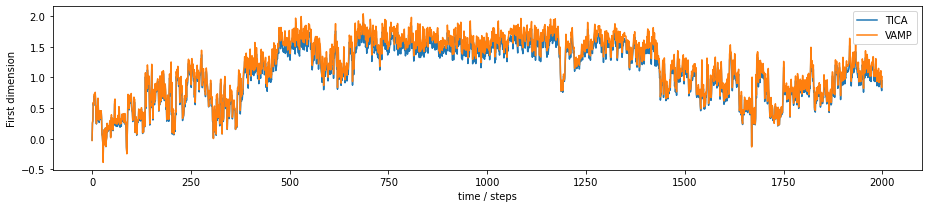

In [15]:
# TICA and VAMP performed almost the same transformation
# Plot the first IC as a time series. 

fig, ax = plt.subplots(figsize=(13, 3))
ax.plot(tica_concatenated[:2000,1], label = 'TICA')
ax.plot(vamp_concatenated[:2000,1], label = 'VAMP')
ax.set_xlabel('time / steps')
ax.set_ylabel('First dimension')
ax.legend()
fig.tight_layout()
plt.savefig(fname = './figures/IC_time_series.png')

In [16]:
# Clustering the TICA subspace into 300 kmeans centers
# Now each frame has been assigned to a discrete state

cluster = pyemma.coordinates.cluster_kmeans(tica, k = 300, max_iter = 100, stride = 10)
dtrajs_concatenated = np.concatenate(cluster.dtrajs)
print(cluster.clustercenters.shape)
print(len(cluster.dtrajs), cluster.dtrajs[0].shape, dtrajs_concatenated.shape)

creating data array:   0%|                                                                        | 0/4 [00:00…

initialize kmeans++ centers:   0%|                                                              | 0/300 [00:00…

kmeans iterations:   0%|                                                                        | 0/100 [00:00…

getting output of KmeansClustering:   0%|                                                         | 0/4 [00:00…

(300, 64)
4 (25001,) (100004,)


alphafold structure on AxesSubplot(0.547727,0.536818;0.352273x0.343182)
alphafold structure on AxesSubplot(0.125,0.125;0.352273x0.343182)
alphafold structure on AxesSubplot(0.547727,0.125;0.352273x0.343182)


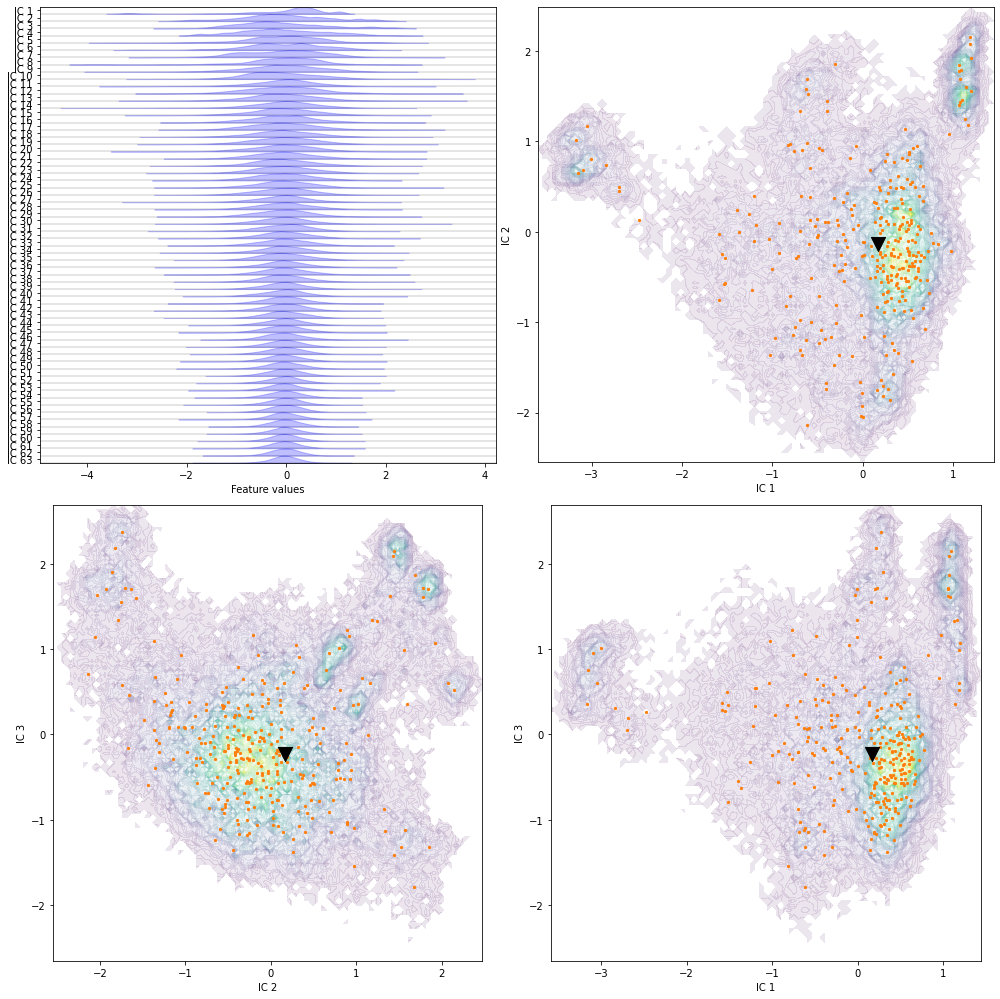

In [147]:
# Plot marginal distributions and pairwise joint distributions of the top three independent components with cluster centers

fig, axes = plt.subplots(2, 2, figsize=(14, 14))
pyemma.plots.plot_feature_histograms(
    tica_concatenated, ['IC {}'.format(i + 1) for i in range(tica.dimension())], ax=axes[0, 0], ignore_dim_warning=True)
for ax, (i, j) in zip(axes.flat[1:], [[0, 1], [1, 2], [0, 2]]):
    pyemma.plots.plot_density(
        *tica_concatenated[:, [i, j]].T, ax=ax, cbar=False, alpha=0.1)
    ax.scatter(*cluster.clustercenters[:, [i, j]].T, s=5, c='C1')
    ax.set_aspect('equal')
    ax.set_xlabel('IC {}'.format(i + 1))
    ax.set_ylabel('IC {}'.format(j + 1))
    for i, (name, obj_list) in enumerate(test_dic.items()):
        print('{} structure on {}'.format(name, ax))
        ax.scatter(*obj_list[1][:,[i,j]].T, s= 200, c = 'k', marker='v')
'''norm = norm, cmap = 'jet', '''
fig.tight_layout()
plt.savefig(fname = './figures/feature_distributions.png')

*** 
### MSM estimation and validation

estimating BayesianMSM:   0%|                                                                     | 0/7 [00:00…

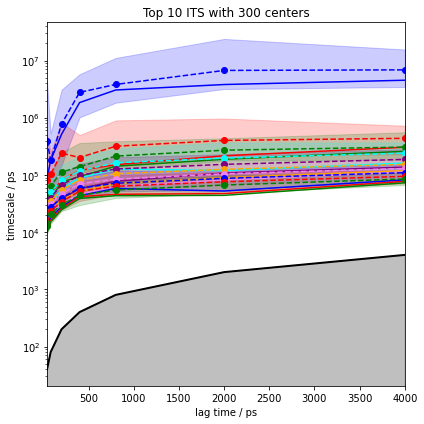

In [135]:
# Plot top 10 implied timescales as a function of lag time
# Each frame correspond to 40 ps

fig, ax = plt.subplots(figsize = (6,6))
its = pyemma.msm.its(cluster.dtrajs, nits = 10, lags = [1, 2, 5, 10, 20, 50, 100], errors='bayes')
pyemma.plots.plot_implied_timescales(its, units = 'ps', dt = 40, ax = ax)
ax.set_title("Top 10 ITS with 300 centers")
fig.tight_layout()
plt.savefig(fname = './figures/10ITS_lag300.png')

AttributeError: 'TICA' object has no attribute '_ra_jagged'

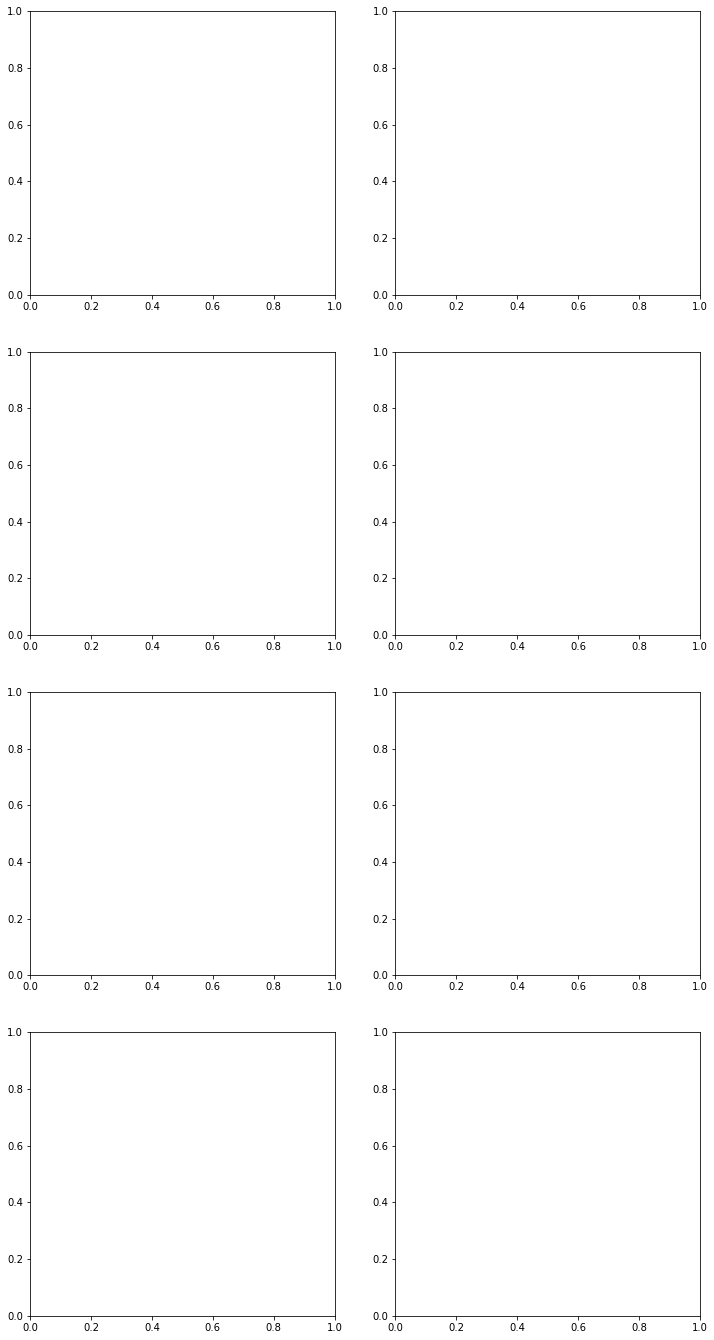

In [109]:
# ITS convergence test for different number of cluster centers

fig, axes = plt.subplots(4, 2, figsize=(12, 24))
for i, k in enumerate([150, 200, 250, 350]):
    cluster_test = pyemma.coordinates.cluster_kmeans(tica, k=k, max_iter=200, stride=10)
    pyemma.plots.plot_density(*tica_concatenated[:,:2].T, ax=axes[i, 0], cbar=False, alpha=0.1)
    axes[i, 0].scatter(*cluster_test.clustercenters[:, :2].T, s=5, c='C1')
    axes[i, 0].set_xlabel('IC1')
    axes[i, 0].set_ylabel('IC2')
    axes[i, 0].set_title('k = {} centers'.format(k))
    pyemma.plots.plot_implied_timescales(pyemma.msm.its(cluster_test.dtrajs, nits=4, lags=[1, 2, 5, 10, 20, 50, 100], errors='bayes'), 
                                         ax=axes[i, 1], units='ps', dt = 40)
    axes[i, 1].set_title('k = {} centers'.format(k))
fig.tight_layout()
plt.savefig(fname = './figures/ITS_compare.png')

In [6]:
# Estimate a MSM and a Bayesian MSM from discrete trajectories
# Save data

#msm = pyemma.msm.estimate_markov_model(cluster.dtrajs, lag = 25, dt_traj = '40 ps')
bayesian_msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag = 25, dt_traj='40 ps', conf = 0.95)

path = r'./models/4us.pyemma'
cluster.save(path, model_name = 'kmeans_300_cluster', overwrite = True)
msm.save(path, model_name = 'msm_lag_50', overwrite = True)
bayesian_msm.save(path, model_name = 'bayesian_msm', overwrite = True)

pyemma.msm.estimators.bayesian_msm.BayesianMSM[8]: compute stat. inefficiencies:   0%|         | 0/3776 [00:00…

pyemma.msm.estimators.bayesian_msm.BayesianMSM[8]: Sampling MSMs:   0%|                         | 0/100 [00:00…

14-10-22 11:04:08 pyemma._base.serialization.h5file INFO     overwriting model "kmeans_300_cluster" in file ./models/3us.pyemma
14-10-22 11:04:08 pyemma._base.serialization.h5file INFO     overwriting model "msm_lag_50" in file ./models/3us.pyemma
14-10-22 11:04:08 pyemma._base.serialization.h5file INFO     overwriting model "bayesian_msm" in file ./models/3us.pyemma


estimating BayesianMSM:   0%|                                                                     | 0/9 [00:00…

/home/rzhu/miniconda3/envs/pyemma_tutorials/lib/python3.9/site-packages/msmtools/analysis/api.py:367: UserWarning: truncated eigendecomposition to contain 299 components
  warnings.warn('truncated eigendecomposition to contain %s components' % new_k, category=UserWarning)
/home/rzhu/miniconda3/envs/pyemma_tutorials/lib/python3.9/site-packages/msmtools/analysis/api.py:367: UserWarning: truncated eigendecomposition to contain 298 components
  warnings.warn('truncated eigendecomposition to contain %s components' % new_k, category=UserWarning)


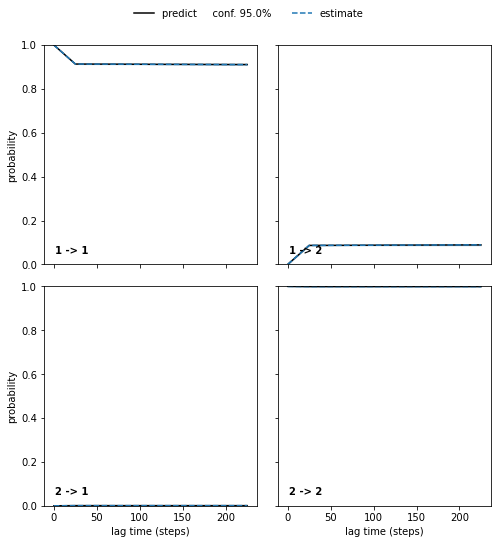

In [4]:
# Then perform a CK test to confirm whether this model satifies Markovianity
# The number of metastable states is chosen to be 2

pyemma.plots.plot_cktest(bayesian_msm.cktest(2), figsize = (8,8))
plt.savefig(fname = './figures/CK_2states_Bayesian.png')

***
### MSM analysis and wrap-up

In [2]:
# Restore data

trj_list = [0,1,2,3]
trj_name = ''.join([str(i) for i in trj_list])

gro = './data/peptide.gro'
trj = [glob.glob('./data/md_1us_*_noPBC.xtc')[i] for i in trj_list]
path = './models/trj{}.pyemma'.format(trj_name)

tica = pyemma.load(path, model_name='tica_trj{}'.format(trj_name))
tica_output = np.load('./models/tica_trj{}.npy'.format(trj_name), allow_pickle=True)
tica_concatenated = np.concatenate(tica_output)
cluster = pyemma.load(path, model_name = 'kmeans_trj{}'.format(trj_name))

cluster_dtrajs = np.load('./models/cluster_dtrajs_trj{}.npy'.format(trj_name), allow_pickle=True)
dtrajs_concatenated = np.concatenate(cluster_dtrajs)
bayesian_msm = pyemma.load(path, model_name='bayesian_msm_trj{}'.format(trj_name)) 

In [88]:
# Regenerate and save tica, clusters, and Bayesian model if necessary

trj_list = [0,1,2,3]
trj_name = ''.join([str(i) for i in trj_list])

gro = './data/peptide.gro'
trj = [glob.glob('./data/md_1us_*_noPBC.xtc')[i] for i in trj_list]
path = './models/trj{}.pyemma'.format(trj_name)

feat = pyemma.coordinates.featurizer(gro)
feat.active_features = []
feat.add_sidechain_torsions(periodic = False)
feat.add_distances_ca(periodic = False)
reader = pyemma.coordinates.source(trj, features = feat)

tica = pyemma.coordinates.tica(reader, lag = 25, var_cutoff = 0.95, stride = 5)
tica.save(path, model_name = 'tica_trj{}'.format(trj_name), overwrite = True)
np.save('./models/tica_trj{}.npy'.format(trj_name), tica.get_output())
tica_concatenated = np.concatenate(tica.get_output())

cluster = pyemma.coordinates.cluster_kmeans(tica, k = 300, max_iter = 100, stride = 5)
cluster.save(path, model_name = 'kmeans_trj{}'.format(trj_name), overwrite = True)
np.save('./models/cluster_dtrajs_trj{}.npy'.format(trj_name), cluster.dtrajs)
cluster_dtrajs = cluster.dtrajs
dtrajs_concatenated = np.concatenate(cluster_dtrajs)

msm = pyemma.msm.estimate_markov_model(cluster.dtrajs, lag = 25, dt_traj='40 ps')
msm.save(path, model_name = 'msm_trj{}'.format(trj_name), overwrite = True)
bayesian_msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag = 25, dt_traj='40 ps', conf = 0.95)
bayesian_msm.save(path, model_name = 'bayesian_msm_trj{}'.format(trj_name), overwrite = True)

/home/rzhu/miniconda3/envs/pyemma_tutorials/lib/python3.9/site-packages/pyemma/coordinates/data/featurization/angles.py:211: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  indices = np.vstack(valid.values())


Obtaining file info:   0%|                                                                        | 0/4 [00:00…

calculate covariances:   0%|                                                                      | 0/4 [00:00…

20-10-22 14:12:03 pyemma._base.serialization.h5file INFO     overwriting model "tica_trj0123" in file ./models/trj0123.pyemma


getting output of TICA:   0%|                                                                     | 0/4 [00:00…

getting output of TICA:   0%|                                                                     | 0/4 [00:00…

creating data array:   0%|                                                                        | 0/4 [00:00…

initialize kmeans++ centers:   0%|                                                              | 0/300 [00:00…

kmeans iterations:   0%|                                                                        | 0/100 [00:00…

20-10-22 14:13:56 pyemma._base.serialization.h5file INFO     overwriting model "kmeans_trj0123" in file ./models/trj0123.pyemma


getting output of KmeansClustering:   0%|                                                         | 0/4 [00:00…

20-10-22 14:14:01 pyemma._base.serialization.h5file INFO     overwriting model "msm_trj0123" in file ./models/trj0123.pyemma


pyemma.msm.estimators.bayesian_msm.BayesianMSM[38]: compute stat. inefficiencies:   0%|        | 0/4758 [00:00…

pyemma.msm.estimators.bayesian_msm.BayesianMSM[38]: Sampling MSMs:   0%|                        | 0/100 [00:00…

20-10-22 14:14:09 pyemma._base.serialization.h5file INFO     overwriting model "bayesian_msm_trj0123" in file ./models/trj0123.pyemma


In [90]:
# Checking msm disconnectivity --- only largest set of reversibly connected discrete states are used in MSM estimation
# If isolated states exist, remove corresponding cluster center (microstate) and inactive frames from the trajectory
# and from TICA space

print('Fraction of states used = {:f}'.format(bayesian_msm.active_state_fraction))
print('Fraction of counts used = {:f}'.format(bayesian_msm.active_count_fraction))
print('Inactive states which have been excluded from estimation: ', set(range(cluster.clustercenters.shape[0]))-set(bayesian_msm.active_set))

print(f'TICA space dimension: {tica_concatenated.shape}')
print(f'Microstate assignment: {dtrajs_concatenated.shape}')
print(f'Cluster center dimension: {cluster.clustercenters.shape}')
print(f'Right eigenvectors dimension: {bayesian_msm.eigenvectors_right().shape}')

Fraction of states used = 1.000000
Fraction of counts used = 1.000000
Inactive states which have been excluded from estimation:  set()
TICA space dimension: (100004, 63)
Microstate assignment: (100004,)
Cluster center dimension: (300, 63)
Right eigenvectors dimension: (300, 300)


In [3]:
# Compute the stationary distribution of metastable states

nstates = 2
msm.pcca(nstates)

print('state\tπ\t\tG/kT\t\tNo.')
for i, s in enumerate(msm.metastable_sets):
    p = msm.pi[s].sum()
    print('{}\t{:f}\t{:f}\t{}'.format(i + 1, p, -np.log(p), s.shape[0]))
    print(s)

NameError: name 'msm' is not defined

In [4]:
# Compute the stationary distribution of metastable states

nstates = 2
bayesian_msm.pcca(nstates)

print('state\tπ\t\tG/kT\t\tNo.')
for i, s in enumerate(bayesian_msm.metastable_sets):
    p = bayesian_msm.pi[s].sum()
    print('{}\t{:f}\t{:f}\t{}'.format(i + 1, p, -np.log(p), s.shape[0]))
    print(s)

state	π		G/kT		No.
1	0.034035	3.380369	291
[  0   1   2   3   4   5   6   7   8  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  32  33  34  35  36  37
  38  39  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  76  77  78  79  80  81  82  83  84  85  86  87  88  90  91  92  93  94
  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112
 113 114 115 117 118 119 120 121 122 123 124 125 127 128 129 130 131 132
 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150
 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168
 169 170 171 172 173 174 175 177 178 179 180 181 182 183 184 185 186 187
 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205
 206 207 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224
 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242
 243 244

In [9]:
# Load test structure for tracking

gro = './data/peptide.gro'
af_path = r'./data/alphafold2.xtc'
npt_path = r'./data/npt.xtc' 

feat = pyemma.coordinates.featurizer(gro)
feat.active_features = []
feat.add_sidechain_torsions(periodic = False)
feat.add_distances_ca(periodic = False)

af = pyemma.coordinates.load(af_path, features = feat)
npt = pyemma.coordinates.load(npt_path, features = feat)

# Prepare output list: #0 original features #1 tica features #2 microstate #3 metastable states
test_dic = {'alphafold': [af]}
#, 'npt': [npt]
for name, obj_list in test_dic.items():
    feat = tica.transform(obj_list[0])
    microstate = cluster.assign(feat)
    metastate = bayesian_msm.metastable_assignments[microstate]
    test_dic[name].extend([feat, microstate, metastate])

/home/rzhu/miniconda3/envs/pyemma_tutorials/lib/python3.9/site-packages/pyemma/coordinates/data/featurization/angles.py:211: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  indices = np.vstack(valid.values())


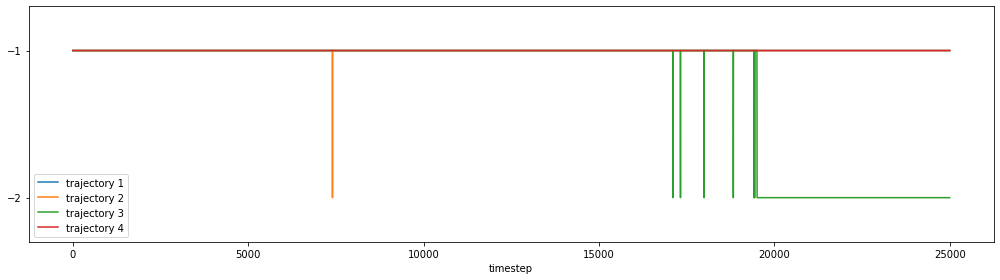

In [92]:
fig, ax = plt.subplots(figsize=(14, 4))

for i,dtraj in enumerate(cluster_dtrajs):
    ax.plot(-bayesian_msm.metastable_assignments[dtraj] - 1 ,label = 'trajectory {}'.format(i+1))

#ax.set_yticklabels()
ax.set_yticks([-2,-1])
ax.set_ylim([-2.3,-0.7])
ax.set_xlabel('timestep')
#ax.set_ylabel('State')
plt.legend(loc='lower left')
fig.tight_layout()

plt.savefig(fname = './figures/state_timeseries_trj{}.png'.format(trj_name))

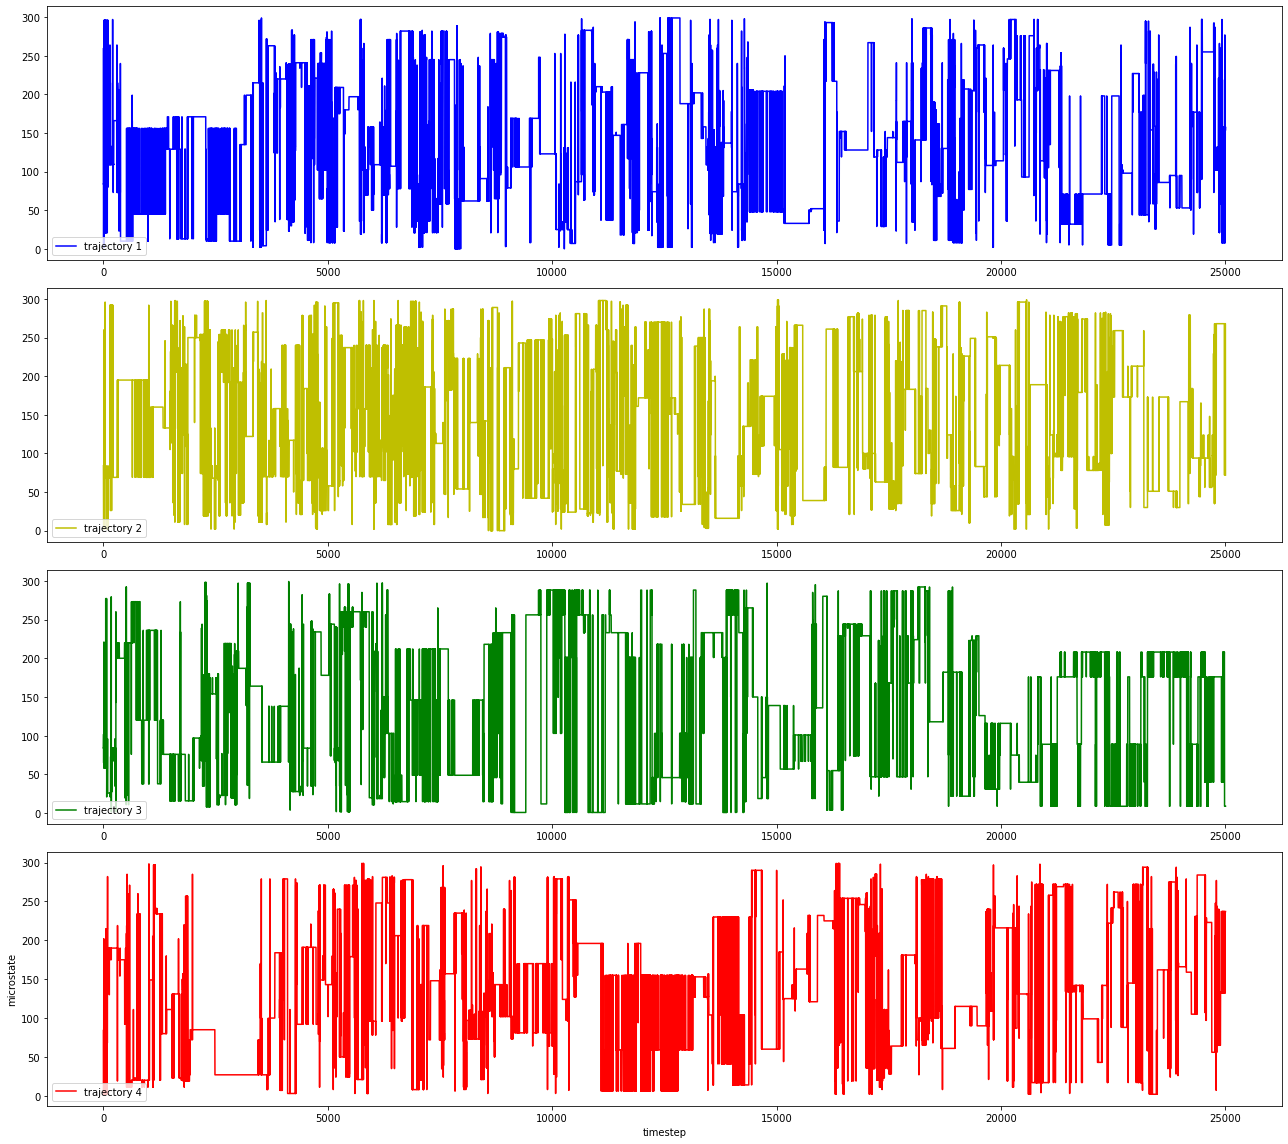

In [104]:
c = ['b','y','g','r']
fig, axes = plt.subplots(4,1,figsize=(18, 16))

for i, ax in enumerate(axes.flat):
    ax.plot(cluster_dtrajs[i], c = c[i], label = 'trajectory {}'.format(i+1))
    ax.legend(loc='lower left')
    
ax.set_xlabel('timestep')
ax.set_ylabel('microstate')
fig.tight_layout()

plt.savefig(fname = './figures/microstate_timeseries_trj{}.png'.format(trj_name))

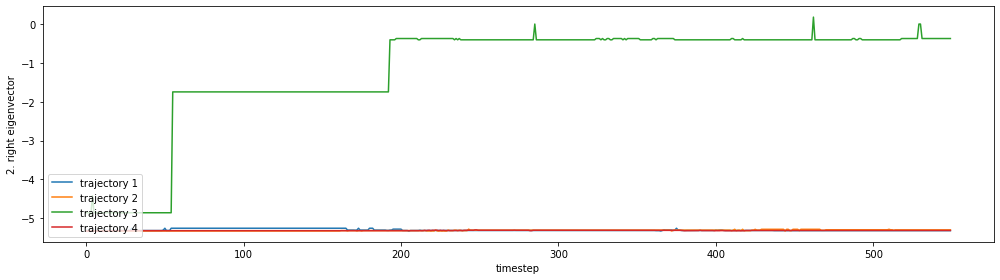

In [20]:
fig, ax = plt.subplots(figsize=(14, 4))

eigvec_2 = bayesian_msm.eigenvectors_right()[:,1]

for i,dtraj in enumerate(cluster_dtrajs):
    ax.plot(eigvec_2[dtraj][19450:20000], label = 'trajectory {}'.format(i+1))

ax.set_xlabel('timestep')
ax.set_ylabel('2. right eigenvector')
#ax.set_ylim([-1.2,4.2])
#ax.set_ylabel('State')
plt.legend(loc='lower left')
fig.tight_layout()

#plt.savefig(fname = './figures/eig2_timeseries_trj{}.png'.format(trj_name))

Position of alphafold: 0.1652560532093048, -0.13732916116714478


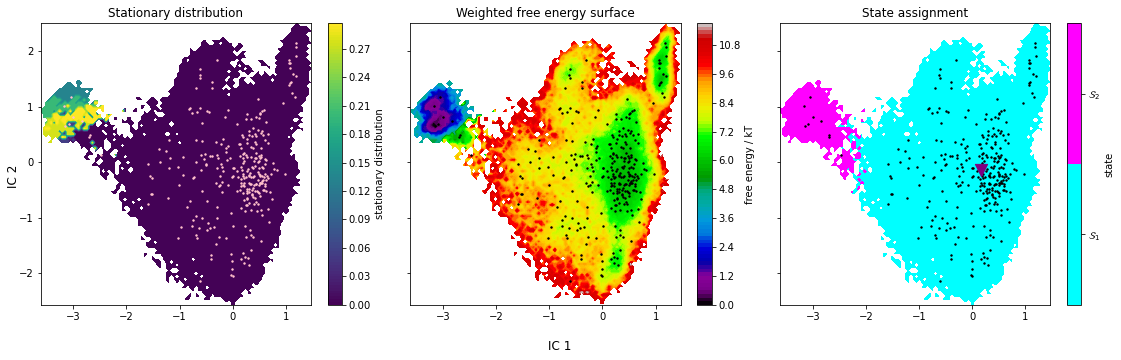

In [12]:
# Plot stationary distribution and reweighted free energy projected onto the first two dimensions
# !Use uniform scale!

metastable_traj = bayesian_msm.metastable_assignments[dtrajs_concatenated]

fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharex=True, sharey=True)
    
pyemma.plots.plot_contour(
    *tica_concatenated[:, :2].T,
    bayesian_msm.pi[dtrajs_concatenated],
    ax=axes[0],
    mask=True,
    cbar_label='stationary distribution')
axes[0].scatter(*cluster.clustercenters[:,:2].T, s=2, c='pink')

pyemma.plots.plot_free_energy(
    *tica_concatenated[:, :2].T,
    weights=np.concatenate(bayesian_msm.trajectory_weights()),
    ax=axes[1],
    legacy=False)
axes[1].scatter(*cluster.clustercenters[:,:2].T, s=2, c='k')

_, _, misc = pyemma.plots.plot_state_map(*tica_concatenated[:, :2].T, metastable_traj, ax=axes[2], cmap = 'cool')
axes[2].scatter(*cluster.clustercenters[:,:2].T, s=2, c='k')
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1) for i in range(nstates)])
for i, (name, conf_list) in enumerate(test_dic.items()):
    x, y = conf_list[1][:, 0],conf_list[1][:, 1]
    print('Position of {}: {}, {}'.format(name, *x,*y))
    axes[2].scatter(x,y,s = 150, c = 'purple',  marker = 'v') 
    
'''i, norm = norm, cmap = 'jet','''    

fig.supxlabel('IC 1')
fig.supylabel('IC 2')
axes[0].set_title('Stationary distribution')
axes[1].set_title('Weighted free energy surface')
axes[2].set_title('State assignment')
fig.tight_layout()

plt.savefig(fname = './figures/stationary_properties_trj{}.png'.format(trj_name))

In [5]:
print(bayesian_msm.pi.argsort()[-10:])
print(bayesian_msm.pi[bayesian_msm.pi.argsort()[-10:]])

[233  27  31 116  75  40   9  89 208 176]
[0.00043629 0.00049373 0.00075089 0.00104291 0.00164296 0.05278456
 0.134991   0.20099554 0.277277   0.29634362]


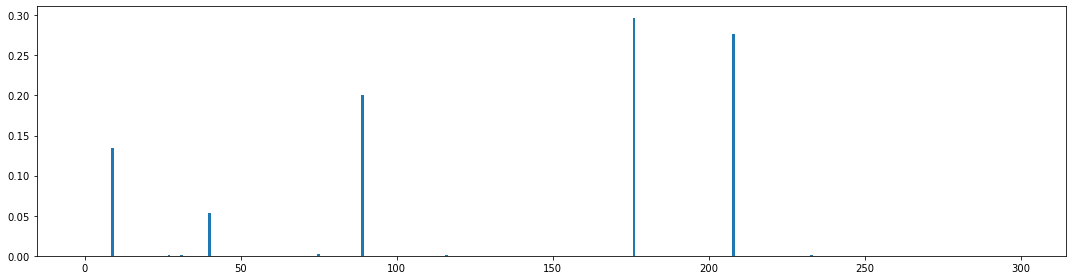

In [6]:
fig, ax = plt.subplots(figsize=(15, 4))
ax.bar(range(0,300), bayesian_msm.pi)
fig.tight_layout()

[ 96 256  16 102  49  89  27 233 208 176]
[0.00787968 0.00793968 0.00805968 0.00861966 0.00871965 0.00904964
 0.01168953 0.0125095  0.01272949 0.01374945]


<function matplotlib.pyplot.show(close=None, block=None)>

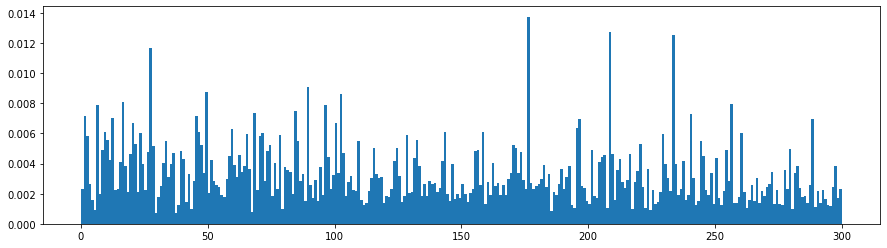

In [8]:
fig, ax = plt.subplots(figsize=(15, 4))
density = np.histogram(dtrajs_concatenated, range(0,301), density = True)[0]
print(density.argsort()[-10:])
print(density[density.argsort()[-10:]])
ax.hist(dtrajs_concatenated, bins = range(0,301), density=True)
plt.show

First rith eigenvector is one: True (min=0.9999999999314593, max=1.0000000000023415)


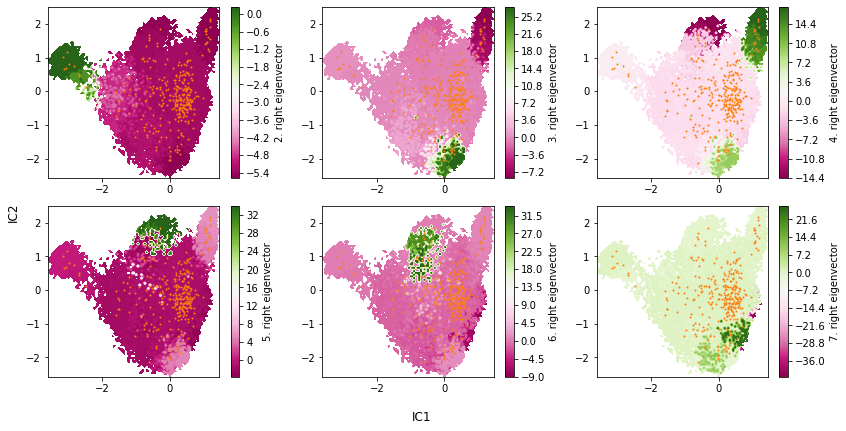

In [106]:
# Plot the top 6 right eigenvalues

eigvec = bayesian_msm.eigenvectors_right()
print('First rith eigenvector is one: {} (min={}, max={})'.format(
    np.allclose(eigvec[:, 0], 1, atol=1e-15), eigvec[:, 0].min(), eigvec[:, 0].max()))

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *tica_concatenated[:,:2].T, eigvec[dtrajs_concatenated, i + 1], ax=ax, cmap='PiYG',
        cbar_label='{}. right eigenvector'.format(i + 2), mask=True)
    ax.scatter(*cluster.clustercenters[:,:2].T, s=1, c='C1')
    ax.set_aspect('equal','box')
fig.supxlabel('IC1')
fig.supylabel('IC2')
fig.tight_layout()
plt.savefig(fname = './figures/top_6_eigenvector_contour_trj{}'.format(trj_name))

First right eigenvector is one: True (min=0.9999999999314593, max=1.0000000000023415)


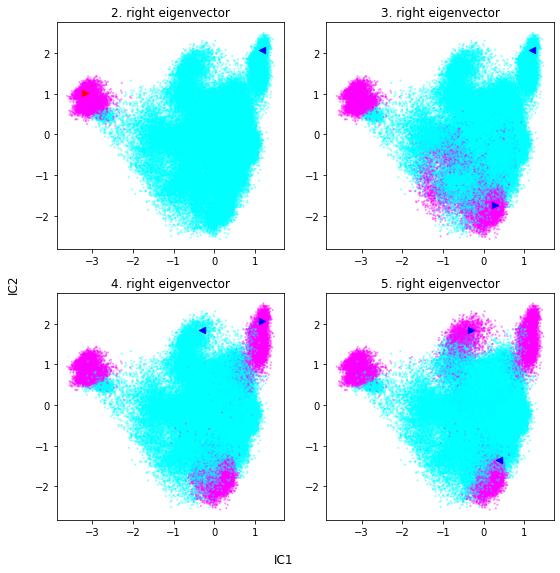

In [113]:
# Plot the right eigenvectors associated with the largest 4 eigenvalues

eigvec = bayesian_msm.eigenvectors_right()
df = pd.DataFrame(eigvec)
print('First right eigenvector is one: {} (min={}, max={})'.format(np.allclose(eigvec[:, 0], 1, atol=1e-15), eigvec[:, 0].min(), eigvec[:, 0].max()))

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    im = ax.scatter(*tica_concatenated[:,:2].T, s = 1.7, c = np.sign(eigvec[dtrajs_concatenated,i+1]), cmap = 'cool', alpha = 0.3)
    ax.set_title('{}. right eigenvector'.format(i + 2))
    ax.set_aspect('equal','box')
    
    max_eig = eigvec[:,i+1].argmax()
    min_eig = eigvec[:,i+1].argmin()
    x,y = cluster.clustercenters[max_eig,0],cluster.clustercenters[max_eig,1]
    ax.scatter(x,y, c = bayesian_msm.metastable_assignments[max_eig], cmap = 'bwr', norm = norm, s=40, marker = '>')
    x,y = cluster.clustercenters[min_eig,0],cluster.clustercenters[min_eig,1]
    ax.scatter(x,y, c = bayesian_msm.metastable_assignments[min_eig], cmap = 'bwr', norm = norm, s=40, marker = '<')    
    
fig.supxlabel('IC1')
fig.supylabel('IC2')

fig.tight_layout()
plt.savefig(fname = './figures/top_4_eigenvectors_sign_trj{}.png'.format(trj_name))

Position of alphafold: 0.1652560532093048, -0.13732916116714478
Position of npt: 0.22210313379764557, -0.04459729045629501


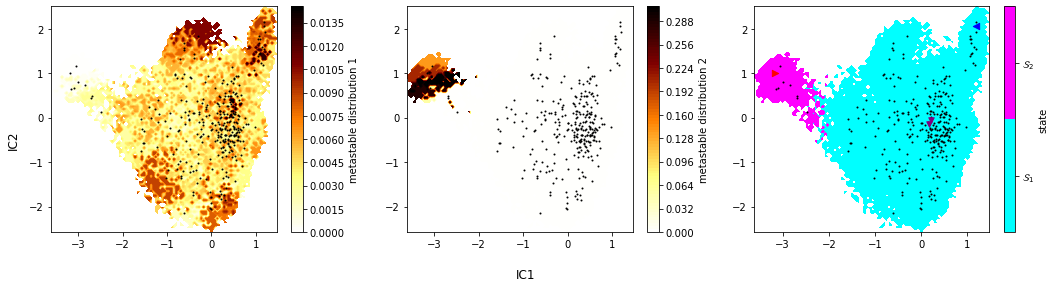

In [108]:
# Membership probability -- the probability of microstates that belong to the same macrostate
# Plot membership distribution

metastable_traj = bayesian_msm.metastable_assignments[dtrajs_concatenated]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, ax in enumerate(axes.flat):
    if i == 2:
        _, _, misc = pyemma.plots.plot_state_map(*tica_concatenated[:, :2].T, metastable_traj, ax=ax, cmap = 'cool')
        ax.scatter(*cluster.clustercenters[:,:2].T, s=1, c='k')
        misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1) for i in range(nstates)])
        for name, conf_list in test_dic.items():
            x, y = conf_list[1][:, 0],conf_list[1][:, 1]
            print('Position of {}: {}, {}'.format(name, *x,*y))
            ax.scatter(x,y,s = 30, c='purple', marker = 'v') 
        max_eig = eigvec[:,1].argmax()
        min_eig = eigvec[:,1].argmin()
        x,y = cluster.clustercenters[max_eig,0],cluster.clustercenters[max_eig,1]
        ax.scatter(x,y, c = bayesian_msm.metastable_assignments[max_eig], cmap = 'bwr', norm = norm, s=40, marker = '>')
        x,y = cluster.clustercenters[min_eig,0],cluster.clustercenters[min_eig,1]
        ax.scatter(x,y, c = bayesian_msm.metastable_assignments[min_eig], cmap = 'bwr', norm = norm, s=40, marker = '<')    
    else:
        pyemma.plots.plot_contour(
            *tica_concatenated[:,:2].T, bayesian_msm.metastable_distributions[i][dtrajs_concatenated], ax=ax, cmap='afmhot_r', 
            mask=True, method='nearest', cbar_label='metastable distribution {}'.format(i + 1))
        ax.scatter(*cluster.clustercenters[:,:2].T, s=1, c='k')
        ax.set_aspect('equal','box')
fig.supylabel('IC2')
fig.supxlabel('IC1')
fig.tight_layout()
plt.savefig(fname = './figures/metastable_distribution_trj{}.png'.format(trj_name))

eigvec 2
max: 89 (0.18962613705716339, 0.0006386606622145814) 0.20099554415079246
min: 49 (-5.550676194503975, -8.313416693840841) 0.0003070186906094253
med: 120 (-5.32263243107081, 0.6962947606350369) 5.5766324716246094e-05
eigvec 3
max: 6 (-5.549439014855273, 27.153402214026073) 0.000328614060393638
min: 49 (-5.550676194503975, -8.313416693840841) 0.0003070186906094253
med: 42 (-5.361898957501492, -0.41389282410524675) 0.0001052540414926954
Position of alphafold: -5.31291269164787, -0.41449560559387383
{'eig2_max': 89, 'eig2_min': 49, 'eig2_med': 120, 'eig3_max': 6, 'eig3_min': 49, 'eig3_med': 42}


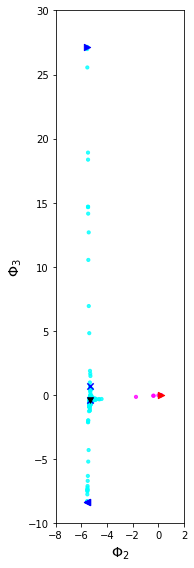

In [156]:
# Plot eigvec 2 against eigvec 3
# Dots are colored according to their metastable assignments

eigvec = bayesian_msm.eigenvectors_right()
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(eigvec[:,1], eigvec[:,2], s=10, c = bayesian_msm.metastable_assignments, cmap = cmap, alpha = 0.8)
norm = Normalize(vmin=0, vmax=1)

eigvec_list = [1,2]
smpl_dic = {}

for eigvec_no in eigvec_list:
    max_eig = eigvec[:,eigvec_no].argmax()
    min_eig = eigvec[:,eigvec_no].argmin()
    med_eig = np.argsort(eigvec[:,eigvec_no])[len(eigvec[:,eigvec_no])//2]
    
    smpl_dic['eig{}_max'.format(eigvec_no+1)] = max_eig
    smpl_dic['eig{}_min'.format(eigvec_no+1)] = min_eig
    smpl_dic['eig{}_med'.format(eigvec_no+1)] = med_eig
    
    max_coord = eigvec[max_eig, 1], eigvec[max_eig, 2]
    min_coord = eigvec[min_eig,1], eigvec[min_eig,2]
    med_coord = eigvec[med_eig,1], eigvec[med_eig,2]
    print('eigvec {}\nmax: {} {} {}\nmin: {} {} {}\nmed: {} {} {}'
          .format(eigvec_no+1, max_eig, max_coord, bayesian_msm.pi[max_eig],
                  min_eig, min_coord, bayesian_msm.pi[min_eig],
                  med_eig, med_coord, bayesian_msm.pi[med_eig]))

    ax.scatter(*max_coord, c = bayesian_msm.metastable_assignments[max_eig], cmap = 'bwr', norm = norm, s=40, marker = '>')
    ax.scatter(*min_coord, c = bayesian_msm.metastable_assignments[min_eig], cmap = 'bwr', norm = norm, s=40, marker = '<')
    ax.scatter(*med_coord, c = bayesian_msm.metastable_assignments[med_eig], cmap = 'bwr', norm = norm, s=40, marker = 'x')

for i, (name, conf_list) in enumerate(test_dic.items()):
    x, y = eigvec[conf_list[2],1], eigvec[conf_list[2],2]
    print('Position of {}: {}, {}'.format(name,*x,*y))
    ax.scatter(x,y,s = 30, c= 'k', marker = 'v')
    
ax.set_aspect('equal')
ax.set_xlabel('$\Phi_2$',fontsize=14)
ax.set_ylabel('$\Phi_3$',fontsize=14)
ax.set_aspect('equal')
ax.set_xticks([-8, -6, -4 ,-2 ,0, 2])
ax.set_ylim([-10,30])
fig.tight_layout()
plt.savefig(fname = './figures/kinetic_maps_trj{}.png'.format(trj_name))
print(smpl_dic)

In [132]:
no = 20
reader = pyemma.coordinates.source(trj, features = feat)

for name, state in smpl_dic.items():
    # Generate samples for each state 
    samples = bayesian_msm.sample_by_state(no, subset=[state])
    samples_extreme = pyemma.coordinates.save_trajs(reader, samples, 
                                                    outfiles=['./data/{}_{}structures.pdb'.format(name,no)])
    # Align samples
    # Compare RMSD within states
    uni = mda.Universe(gro,'./data/{}_{}structures.pdb'.format(name,no), dt = 40)
    matrix = diffusionmap.DistanceMatrix(uni, select='name CA').run()
    aligner = align.AlignTraj(uni, uni, select='name CA', filename= './data/{}_{}structures_aligned.pdb'.format(name,no)).run()
    uni_aligned = mda.Universe(gro,'./data/{}_{}structures_aligned.pdb'.format(name,no), dt = 40)
    matrix_aligned = diffusionmap.DistanceMatrix(uni_aligned, select='name CA').run()
    print('Averaged pairwise RMSD of {} structures before [{}({})] and after [{}({})] alignment'.format(name, matrix.dist_matrix.mean(), matrix.dist_matrix.std(), matrix_aligned.dist_matrix.mean(),matrix_aligned.dist_matrix.std()))

# Compute RMSD between extreme states
for eigvec_no in eigvec_list:
    max_traj = mda.Universe(gro,'./data/eig{}_max_{}structures_aligned.pdb'.format(eigvec_no+1, no), dt = 40)
    min_traj = mda.Universe(gro,'./data/eig{}_min_{}structures_aligned.pdb'.format(eigvec_no+1, no), dt = 40)
    prmsd = np.zeros((no,no))
    for i, frame_max in enumerate(max_traj.trajectory):
        r = rms.RMSD(min_traj, max_traj, select='name CA', ref_frame=i).run()
        prmsd[i] = r.rmsd[:, -1]
    #rmsds = align.alignto(max_traj, min_traj, select='name CA', match_atoms=True)
    print('Averaged RMSD between eig{} max and min structures: {}({})'.format(eigvec_no+1, prmsd.mean(), prmsd.std()))

Obtaining file info:   0%|                                                                        | 0/4 [00:00…

Averaged pairwise RMSD of eig2_max structures before [8.551243370190562(3.22442790705584)] and after [0.9595478814036124(0.3850075409372536)] alignment
Averaged pairwise RMSD of eig2_min structures before [7.96649012185(2.755122975322737)] and after [1.44701741763744(0.6825722467142502)] alignment
Averaged pairwise RMSD of eig2_med structures before [7.501899055098707(2.9648464435745603)] and after [2.143003491608063(0.9597595512463489)] alignment
Averaged pairwise RMSD of eig3_max structures before [9.418834178483394(3.4571590281362585)] and after [1.5787129547580665(0.8168793487679066)] alignment
Averaged pairwise RMSD of eig3_min structures before [7.755946882195132(2.681325170841224)] and after [1.4271092344609229(0.7470970288618024)] alignment
Averaged pairwise RMSD of eig3_med structures before [8.631425272672107(3.2443073219714185)] and after [1.7705977411202534(0.6170358436973827)] alignment
Averaged RMSD between eig2 max and min structures: 4.920165592315167(0.2220623000579215

In [111]:
# Generate a number of representative molecular structures for each metastable state

pcca_samples = bayesian_msm.sample_by_distributions(bayesian_msm.metastable_distributions, 10)
reader = pyemma.coordinates.source(trj, features = feat)
samples_by_metastable = pyemma.coordinates.save_trajs(reader, pcca_samples, 
                                                      outfiles=['./data/pcca_{}_10samples.pdb'.format(n + 1) for n in range(bayesian_msm.n_metastable)])
print(len(samples_by_metastable))

Obtaining file info:   0%|                                                                        | 0/4 [00:00…

2


In [134]:
# Compute mean first passage time (MFPT) -- an average timescale for a transition event to first occur

mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        mfpt[i, j] = bayesian_msm.mfpt(
            bayesian_msm.metastable_sets[i],
            bayesian_msm.metastable_sets[j])

print('MFPT / steps:')
pd.DataFrame(np.round(mfpt, decimals=1), index=range(1, nstates + 1), columns=range(1, nstates + 1))

MFPT / steps:


,1,2
1,0.0,2690132.6
2,94665502.0,0.0


***
### Computing observables

In [134]:
gro = './data/peptide.gro'
trj = glob.glob('./data/md_1us_*_noPBC.xtc')
feat = pyemma.coordinates.featurizer(gro)
feat.active_features = []
feat.add_sidechain_torsions(periodic = False)
feat.add_distances_ca(periodic = False)
reader = pyemma.coordinates.source(trj, features = feat)
                                   
# Generate 100 sample for each metastable membership distribution
sample_by_metastable_distributions = bayesian_msm.sample_by_distributions(bayesian_msm.metastable_distributions, 100)
print('Sample for {} metastable states'.format(len(sample_by_metastable_distributions)))

# Generate 10 samples for each microstate
sample_by_microstate = [smpl for smpl in bayesian_msm.sample_by_state(20)]
print('Sample for {} states'.format(len(sample_by_microstate)))

# Save generated molecular structures in trajectories
metastable_samples = [pyemma.coordinates.save_traj(reader, smpl, outfile=None, top=gro) for smpl in sample_by_metastable_distributions]
microstate_samples = [pyemma.coordinates.save_traj(reader, smpl, outfile=None, top=gro) for smpl in sample_by_microstate]

# Compute both observables
metastable_rg_all = [compute_rg(sample) for sample in metastable_samples]
metastable_sasa_all = [np.sum(shrake_rupley(sample, mode='residue'), axis = 1) for sample in metastable_samples]
markov_average_rg = [compute_rg(sample).mean() for sample in microstate_samples]
markov_average_sasa = [shrake_rupley(sample, mode='residue').sum(axis = 1).mean() for sample in microstate_samples]

# Weigh both observables over msm
equilibrium_rg = bayesian_msm.expectation(markov_average_rg)
equilibrium_sasa = bayesian_msm.expectation(markov_average_sasa)
equilibrium_std_rg = bayesian_msm.sample_std('expectation', markov_average_rg)
equilibrium_std_sasa = bayesian_msm.sample_std('expectation', markov_average_sasa)

# Compute mean and std gyration and sasa for each set of representative structures
metastable_average_rg, metastable_std_rg = np.array(metastable_rg_all).mean(axis=1), np.array(metastable_rg_all).std(axis=1)
metastable_average_sasa, metastable_std_sasa = np.array(metastable_sasa_all).mean(axis=1), np.array(metastable_sasa_all).std(axis=1)

dataframe_dict = {'metastable_state': [1,2, 'equilibrium'], 
                  'mean_rg' : np.append(metastable_average_rg,equilibrium_rg), 
                  'std_rg' : np.append(metastable_std_rg, equilibrium_std_rg),
                  'mean_sasa' : np.append(metastable_average_sasa, equilibrium_sasa), 
                  'std_sasa': np.append(metastable_std_sasa, equilibrium_std_sasa)}

results = pd.DataFrame(dataframe_dict).set_index('metastable_state')
results.to_csv('./figures/observables_{}.csv'.format(trj_name), index = False)
results

/home/rzhu/miniconda3/envs/pyemma_tutorials/lib/python3.9/site-packages/pyemma/coordinates/data/featurization/angles.py:211: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  indices = np.vstack(valid.values())


Obtaining file info:   0%|                                                                        | 0/4 [00:00…

Sample for 2 metastable states
Sample for 300 states


,mean_rg,std_rg,mean_sasa,std_sasa
metastable_state,,,,
1,0.809727,0.117559,17.282629,1.608267
2,0.692693,0.012623,15.274827,0.418168
equilibrium,0.700461,0.017251,15.379551,0.320967


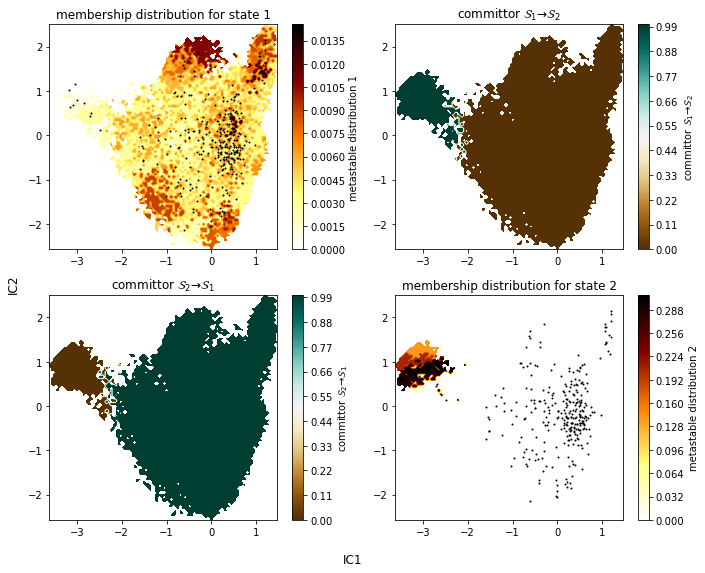

In [142]:
# Plot committor distributions
# For subplots on the diagonal plot membership distribution for that metastable state

nstate = 2
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for i in range(nstate):
    for j in range(nstate):
        if i == j:
            pyemma.plots.plot_contour(
            *tica_concatenated[:,:2].T, bayesian_msm.metastable_distributions[i][dtrajs_concatenated], ax=axes[i,j], cmap='afmhot_r', 
            mask=True, method='nearest', cbar_label='metastable distribution {}'.format(i + 1))
            axes[i,j].scatter(*cluster.clustercenters[:,:2].T, s=1, c='k')
            axes[i,j].set_title('membership distribution for state {}'.format(i+1))
        else:
            A = bayesian_msm.metastable_sets[i]
            B = bayesian_msm.metastable_sets[j]
            flux = pyemma.msm.tpt(bayesian_msm, A, B)
            pyemma.plots.plot_contour(
                *tica_concatenated[:, :2].T,
                flux.committor[dtrajs_concatenated],
                cmap='BrBG',
                ax=axes[i,j],
                mask=True,
                cbar_label=r'committor $\mathcal{S}_%d \to \mathcal{S}_%d$' % (i + 1, j + 1))
            axes[i,j].set_title(r'committor $\mathcal{S}_%d \to \mathcal{S}_%d$' % (i + 1, j + 1))
fig.supxlabel('IC1')
fig.supylabel('IC2')
fig.tight_layout()
plt.savefig(fname = './figures/committors_trj{}.png'.format(trj_name))